# Simulation of one voxel encoding for different probabilities



In [39]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
#import decimal
# import matplotlib
# matplotlib.use('Agg')    # To avoid bugs
import matplotlib.pyplot as plt
import matplotlib
width = 18
height = 16
#matplotlib.rcParams['figure.figsize'] = [width, height]
import pandas as pd

import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils

# But final : avoir tous les paramètres pour temps de l'expérience, etc. tout en haut, pouvoir exporter un
# fichier léger avec bcp d'expériences depuis Matlab, et le charger en Python (ASCI)

In [40]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [41]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(5);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored
N_array = np.array([2, 4, 6, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20#

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 5

# The number of sessions
n_sessions = 4

# The number of stimuli per session
n_stimuli = 380

# Way to compute the distributions from the sequence
distrib_type = 'HMM'

# Load the corresponding data
[p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli,
                                                                                      distrib_type)

# Experimental options
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12
max_n_local_regular_stimuli = 18

# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner

between_scans_duration = 2  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


# Type of regression
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)
regr2 = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)

whitening_done = False


## Handle the data

### Row data loading and visualization


In [42]:
# Load the design matrices and specify their size
with open("output/design_matrices/X_par1.txt", "rb") as fp: #X_20sub_f.txt", "rb") as fp:   # Unpickling
    X = pickle.load(fp)


In [43]:
print(np.mean(X[0][0][0][0][:, 1]))

8.733087258689868e-05


In [44]:
# Just for now
n_subjects = 2
n_sessions = 4
n_N = len(N_array)
n_schemes = 4

In [45]:
# Create X
fmri_gain = 1    # Amplification of the signal

# Initialization of the design matrices and their zscore versions
X = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_fit_scheme in range(n_schemes)]

### WE BEGIN BY CREATING THE DESIGN MATRIX X
start = time.time()

for k_subject in range(n_subjects):
    ### Loop over the sessions : we start with it in order to have the same length whatever N_fit is
    for k_session in range(n_sessions):
        # Get the data of interest
        mu = p1_mu_array[k_subject, k_session, :n_stimuli]
        sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
        conf = -np.log(sigma)
        dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]

        # Formatting
        simulated_distrib = [None for k in range(n_stimuli)]
        for k in range(n_stimuli):
            # Normalization of the distribution
            norm_dist = dist[:, k] * (len(dist[1:, k]) - 1) / np.sum(dist[1:, k])
            simulated_distrib[k] = distrib(mu[k], sigma[k], norm_dist)

        # Experimental design information
        eps = 1e-5  # For floating points issues
        initial_time = between_stimuli_duration + eps
        final_time_tmp = between_stimuli_duration * (n_stimuli + 1) + eps
        # Every 15+-3 trials : one interruption of 8-12s
        stimulus_onsets = np.linspace(initial_time, final_time_tmp, n_stimuli)
        # We add some time to simulate breaks
        stimulus = 0

        while True:
            # Number of regularly spaced stimuli
            n_local_regular_stimuli = rand.randint(min_n_local_regular_stimuli, max_n_local_regular_stimuli)
            stimulus_shifted = stimulus + n_local_regular_stimuli  # Current stimulus before the break
            if stimulus_shifted > n_stimuli:  # The next break is supposed to occur after all stimuli are shown
                break
            stimulus_onsets[stimulus_shifted:] += rand.randint(min_break_time,
                                                               max_break_time) - between_stimuli_duration  # We consider a break of 8-12s
            stimulus = stimulus_shifted

        stimulus_durations = dt * np.ones_like(stimulus_onsets)  # Dirac-like stimuli

        # fMRI information
        final_time = stimulus_onsets[-1]
        final_frame_time = final_time + final_frame_offset

        initial_scan_time = initial_frame_time + between_scans_duration
        final_scan_time = final_time + final_scan_offset
        scan_times = np.arange(initial_scan_time, final_scan_time, between_scans_duration)

        # Creation of fmri object
        simu_fmri = fmri(initial_frame_time, final_frame_time, dt, scan_times)

        # Creation of experiment object
        exp = experiment(initial_time, final_time, n_sessions, stimulus_onsets, stimulus_durations, simulated_distrib)

        ### LOOP OVER THE SCHEME
        for k_fit_scheme in range(n_schemes):

            # Current schemes
            fit_scheme = scheme_array[k_fit_scheme]

            ### LOOP OVER THE FIT N's
            for k_fit_N in range(n_N):
                # Current N
                fit_N = N_array[k_fit_N]

                # Creation of the true tuning curve objects

                # We replace the right value of the "t"'s according to the type of tuning curve and the N
                if fit_scheme.find('gaussian') != -1:
                    fit_t_mu = t_mu_gaussian_array[k_fit_N]
                    fit_t_conf = t_conf_gaussian_array[k_fit_N]
                    fit_tc_type = 'gaussian'

                elif fit_scheme.find('sigmoid') != -1:
                    fit_t_mu = t_mu_sigmoid_array[k_fit_N]
                    fit_t_conf = t_conf_sigmoid_array[k_fit_N]
                    fit_tc_type = 'sigmoid'

                fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                             tc_upper_bound_conf)

                if fit_scheme.find('ppc') != -1:
                    fit_tc = [fit_tc_mu, fit_tc_conf]
                elif fit_scheme.find('dpc') != -1:
                    fit_tc = [fit_tc_mu]
                elif fit_scheme.find('rate') != -1:
                    fit_tc = []

                # Regressor and BOLD computation
                X[k_fit_scheme][k_fit_N][k_subject][k_session] = simu_fmri.get_regressor(exp, fit_scheme, fit_tc)
                # Just to have Xz with np array of the right structure
    end = time.time()
    print('Design matrix creation : Subject n'+str(k_subject)+' is done ! Time elapsed : '+str(end-start)+'s')

## Save this matrix
#with open("output/design_matrices/X_par.txt", "wb") as fp:   #Pickling
#    pickle.dump(X, fp)



Design matrix creation : Subject n0 is done ! Time elapsed : 2.422212839126587s
Design matrix creation : Subject n1 is done ! Time elapsed : 4.8047709465026855s


X of size : (355, 16)
Scheme : gaussian_ppc
N=8
Subject n°1
Session n°2

Tuning curve n°1 related to mu
X of size : (355, 16)
Scheme : gaussian_ppc
N=8
Subject n°1
Session n°2

Tuning curve n°1 related to the confidence


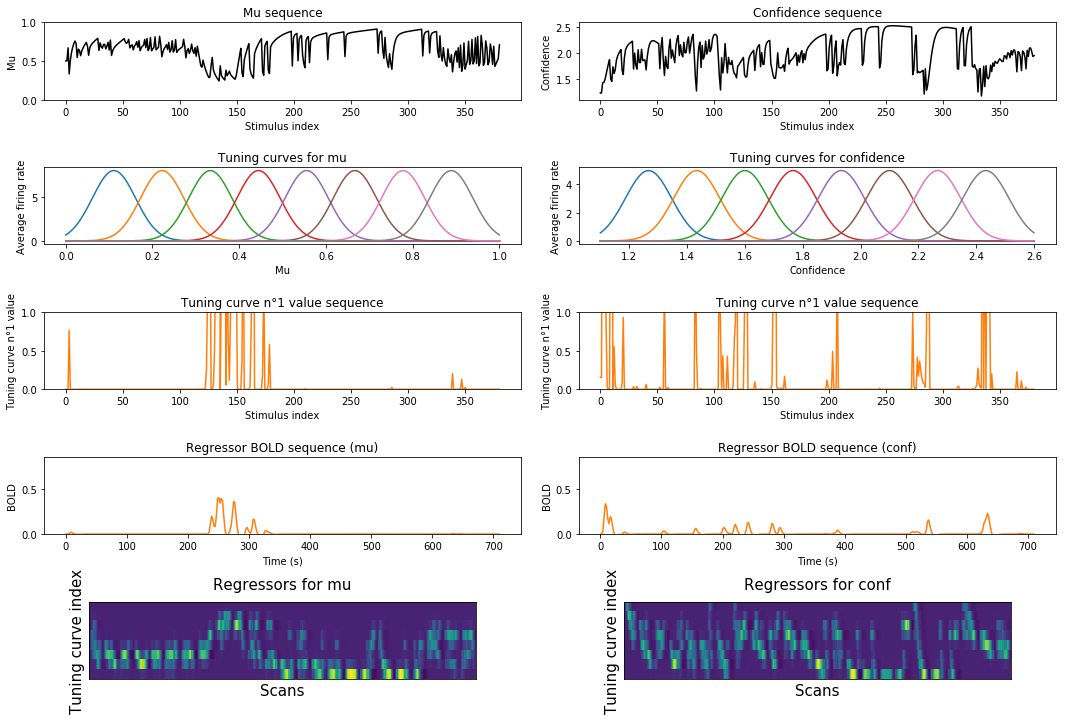

In [46]:
# Plot signal compared to summary statistics for the desired model
######################################################################################
k_scheme = 0
k_N = 3
k_fit_N =3
k_true_N =3
k_fraction =9
k_subject = 1
k_session = 2
n_stimuli = 380
#######################################################################################
# Tuning curve indices to visualize
i_mu = 1
i_conf = 1

# Test everything is fine
mu = p1_mu_array[k_subject, k_session, :n_stimuli]
sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
conf = -np.log(sigma)
dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]

scheme = scheme_array[k_scheme]
N = N_array[k_N]

# For gaussian PPC
if scheme.find('gaussian')!=-1:
    tc_type = 'gaussian'
    # For mu
    t_mu = t_mu_gaussian_array[k_N]
elif scheme.find('sigmoid')!=-1:
    tc_type = 'sigmoid'
    # For mu
    t_mu = t_mu_sigmoid_array[k_N]

tc_mu = tuning_curve(tc_type, N, t_mu, tc_lower_bound_mu, tc_upper_bound_mu)

tc_signal_mu =  tc_mu.f(mu, i_mu)

print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
data_signal_mu = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, i_mu])

n_scans = X[k_scheme][k_N][k_subject][k_session].shape[0]

# for color plots of all tuning curves
data_mu = np.zeros((N, n_scans))
for idx_mu in range(N):
    data_mu[idx_mu, :] = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, idx_mu])

bold_max = np.max(X[k_scheme][k_N][k_subject][k_session].flatten())

print('Scheme : '+scheme_array[k_scheme])
print('N='+str(N))
print('Subject n°'+str(k_subject))
print('Session n°'+str(k_session)+'\n')
print('Tuning curve n°'+str(i_mu)+' related to mu')

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # For gaussian PPC
    if scheme.find('gaussian')!=-1:
        tc_type = 'gaussian'
        t_conf = t_conf_gaussian_array[k_N]
    elif scheme.find('sigmoid')!=-1:
        tc_type = 'sigmoid'
        t_conf = t_conf_sigmoid_array[k_N]
        
    tc_conf = tuning_curve(tc_type, N, t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

    tc_signal_conf =  tc_conf.f(conf, i_conf)
    print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
    data_signal_conf = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+i_conf])
    data_conf = np.zeros((N, n_scans))
    for idx_conf in range(N):
        data_conf[idx_conf, :] = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+idx_conf])

    print('Scheme : '+scheme_array[k_scheme])
    print('N='+str(N))
    print('Subject n°'+str(k_subject))
    print('Session n°'+str(k_session)+'\n')
    print('Tuning curve n°'+str(i_conf)+' related to the confidence')


### VISUALIZATION

fig = plt.figure(figsize=(15, 10))

# Mu sequence

ax1_up = fig.add_subplot(521)
ax1_up.plot(np.linspace(0, len(mu), len(mu)), mu, color='black')
ax1_up.set_xlabel('Stimulus index')
ax1_up.set_ylabel('Mu')
ax1_up.set_title('Mu sequence')
ax1_up.set_ylim(0, 1)

# Tuning curves
ax1_down = fig.add_subplot(523)
mu = np.linspace(tc_lower_bound_mu, tc_upper_bound_mu, 1000)
tc_color = [None for k in range(N)]
for k in range(N):
    p = ax1_down.plot(mu, tc_mu.f(mu, k))
    tc_color[k] = p[0].get_color()
ax1_down.set_xlabel('Mu')
ax1_down.set_ylabel('Average firing rate')
ax1_down.set_title('Tuning curves for mu')

# Tuning curve value sequence
ax_up = fig.add_subplot(525)
ax_up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_mu, color=tc_color[i_mu])
ax_up.set_xlabel('Stimulus index')
ax_up.set_ylim(0, 1)
ax_up.set_ylabel('Tuning curve n°'+str(i_mu)+' value')
ax_up.set_title('Tuning curve n°'+str(i_mu)+' value sequence')

ax_down = fig.add_subplot(527)
between_scans_time = 2.0
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor BOLD sequence (mu)')
ax_down.set_ylim(0, bold_max)
ax_down.plot(np.linspace(0, between_scans_time*len(data_signal_mu), len(data_signal_mu)), data_signal_mu, color=tc_color[i_mu])

ax = fig.add_subplot(529)
heatmap = ax.imshow(data_mu, extent=[0, 5, 0, 1])
# put the major ticks at the middle of each cell
ax.set_xticks([])
ax.set_yticks([])

fontsize = 15
# # want a more natural, table-like display
ax.xaxis.tick_top()
ax.set_ylabel('Tuning curve index', fontsize=fontsize)
ax.set_xlabel('Scans', fontsize=fontsize)
ax.set_title('Regressors for mu', y=1.08, fontsize=fontsize)

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # Confidence sequence
    conf = -np.log(p1_sd_array[k_subject, k_session, :n_stimuli])
    ax1__up = fig.add_subplot(522)
    ax1__up.plot(np.linspace(0, len(conf), len(conf)), conf, color='black')
    ax1__up.set_xlabel('Stimulus index')
    ax1__up.set_ylabel('Confidence')
    ax1__up.set_title('Confidence sequence')

    # Tuning curves
    ax1__down = fig.add_subplot(524)
    conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
    tc_color = [None for k in range(N)]
    for k in range(N):
        p = ax1__down.plot(conf, tc_conf.f(conf, k))
        tc_color[k] = p[0].get_color()
    ax1__down.set_xlabel('Confidence')
    ax1__down.set_ylabel('Average firing rate')
    ax1__down.set_title('Tuning curves for confidence')

    # Tuning curve value sequence
    ax__up = fig.add_subplot(526)
    ax__up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_conf, color=tc_color[i_conf])
    ax__up.set_xlabel('Stimulus index')
    ax__up.set_ylim(0, 1)
    ax__up.set_ylabel('Tuning curve n°'+str(i_conf)+' value')
    ax__up.set_title('Tuning curve n°'+str(i_conf)+' value sequence')

    ax__down = fig.add_subplot(528)
    between_scans_time = 2.0
    ax__down.set_xlabel('Time (s)')
    ax__down.set_ylabel('BOLD')
    ax__down.set_title('Regressor BOLD sequence (conf)')
    ax__down.set_ylim(0, bold_max)
    ax__down.plot(np.linspace(0, between_scans_time*len(data_signal_conf), len(data_signal_conf)), data_signal_conf, color=tc_color[i_conf])
    
    ax = fig.add_subplot(5,2,10)
    heatmap = ax.imshow(data_conf, extent=[0, 5, 0, 1])
    # put the major ticks at the middle of each cell
    ax.set_xticks([])
    ax.set_yticks([])

    # # want a more natural, table-like display
    ax.xaxis.tick_top()
    ax.set_ylabel('Tuning curve index', fontsize=fontsize)
    ax.set_xlabel('Scans', fontsize=fontsize)
    ax.set_title('Regressors for conf', y=1.08, fontsize=fontsize)

fig.tight_layout()
plt.show()

# Future whitening visualization (with mu)
X_before_whitening = copy.deepcopy(X)

# Vecteur de couleur : imagesc, niveau d'activité = couleur


### Whiten the design matrix

In [47]:
# Whiten the design matrices

# Whitening matrix
white_mat = sio.loadmat('data/simu/whitening_matrix.mat')
W = white_mat['W']
# Complete the in-between session "holes"
W[300:600, 300:600] = W[20:320, 20:320]

if not whitening_done:
    # Multiplying the zscored X with the whitening matrix
    for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
        X_tmp = copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session])    # Just to lighten code
        rows_dim, columns_dim = X_tmp.shape
        X_tmp = np.matmul(W[:rows_dim, :rows_dim], X_tmp)
        X[k_scheme][k_fit_N][k_subject][k_session] = copy.deepcopy(X_tmp)

whitening_done = True

X_after_whitening = copy.deepcopy(X)

### Computes the response vectors


In [48]:
# Creation of y from X to save computational resources
# Initialization of the response vectors
y = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

# Initialization of the weights
weights = [[[[None for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)] for k_true_N in range(n_N)]
           for k_scheme in range(n_schemes)]


### LOOP OVER THE SCHEME
for k_scheme in range(n_schemes):
    true_scheme = scheme_array[k_scheme]

    # We replace the right value of the "t"'s according to the type of tuning curve

    if true_scheme.find('gaussian') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_gaussian_array)
        true_t_conf_array = copy.deepcopy(t_conf_gaussian_array)
        true_tc_type = 'gaussian'

    elif true_scheme.find('sigmoid') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_sigmoid_array)
        true_t_conf_array = copy.deepcopy(t_conf_sigmoid_array)
        true_tc_type = 'sigmoid'

    # We consider combinations of population fractions for PPC and rate codes
    if true_scheme.find('ppc') != -1 or true_scheme.find('rate') != -1:
        # The number of population fraction tested (related to W)
        population_fraction_array = copy.deepcopy(np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]]))
    elif true_scheme.find('dpc') != -1:  # DPC case
        population_fraction_array = copy.deepcopy(np.array([[1]]))
    n_population_fractions = len(population_fraction_array)

    ### LOOP OVER N_true
    for k_true_N in range(n_N):
        true_N = N_array[k_true_N]
        # Creation of the true tuning curve objects
        true_t_mu = true_t_mu_array[k_true_N]
        true_t_conf = true_t_conf_array[k_true_N]
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)

        if true_scheme.find('ppc') != -1:
            true_tc = [true_tc_mu, true_tc_conf]
        elif true_scheme.find('dpc') != -1:
            true_tc = [true_tc_mu]
        elif true_scheme.find('rate') != -1:
            true_tc = []

        ### LOOP OVER THE SUBJECTS
        for k_subject in range(n_subjects):

            ### LOOP OVER THE W's
            # The number of subpopulation fractions acc. to the scheme
            n_subpopulation_fractions = int(n_fractions / n_population_fractions)
            fraction_counter = 0
            for k_subpopulation_fraction in range(n_subpopulation_fractions):
                for k_population_fraction, population_fraction in enumerate(population_fraction_array):
                    # The number of populations acc. to the scheme (2 for PPC and rate, 1 for DPC)
                    n_population = len(population_fraction)
                    if true_scheme.find('ppc') != -1 or true_scheme.find('dpc') != -1:
                        # We consider one sparsity per remainder value of the counter divided by the number
                        # of combinations to be tested
                        subpopulation_sparsity_exp = sparsity_exp_array[fraction_counter % n_sparsity_exp]
                        # Fraction of each neural subpopulation
                        subpopulation_fraction = neural_proba.get_subpopulation_fraction(n_population, true_N,
                                                                                         subpopulation_sparsity_exp)
                    else:  # Rate case
                        population_fraction = np.array([1, 1])

                    # Generate the data from the voxel
                    true_voxel = voxel(true_scheme, population_fraction, subpopulation_fraction, true_tc)
                    n_true_features = n_population * true_N
                    weights_tmp = copy.deepcopy(np.reshape(true_voxel.weights, (n_true_features,)))

                    # Allocation of the weight tensor
                    weights[k_scheme][k_true_N][fraction_counter][k_subject] \
                        = copy.deepcopy(weights_tmp)

                    ### LOOP OVER THE SESSIONS : simulating the response
                    for k_session in range(n_sessions):
                            # We use X to compute y order to save some computation time
                            # Temporary variables to lighten the reading
                            y[k_scheme][k_true_N][fraction_counter][k_subject][
                                k_session] = copy.deepcopy(np.matmul(X[k_scheme][k_true_N][k_subject][k_session], weights_tmp))
                    fraction_counter += 1

y_without_noise = copy.deepcopy(y)
# with open("output/design_matrices/y_20sub.txt", "wb") as fp:   #Pickling
#     pickle.dump(y, fp)


### Noise injection in the responses


In [49]:
noise_sd = np.load('output/noise_sd.npy')
print(noise_sd)

[[0.05365317 0.0355532  0.02024917 0.01898592 0.01174376 0.00778929
  0.00563796]
 [0.04830356 0.04432882 0.05797481 0.05129981 0.040141   0.05282823
  0.04361553]
 [0.04134219 0.0273515  0.01804975 0.01268317 0.01029137 0.00723727
  0.00501152]
 [0.04805728 0.04886923 0.05365327 0.04654554 0.05169722 0.04469682
  0.04403116]]


In [50]:

# Compute the amplitude of the noise
noise_sd = np.zeros((n_schemes, n_N))
added_noise = np.zeros((n_schemes, n_N, 1000))
for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    all_y = np.asarray(y[k_scheme][k_true_N]).flatten()  # Concatenation of all y grouped together for SNR computation
    noise_sd[k_scheme, k_true_N] = np.sqrt(np.var(all_y[0]) * (1 / snr - 1))  # std of the added gaussian noise
    added_noise[k_scheme, k_true_N, :] = np.random.normal(0, noise_sd[k_scheme, k_true_N], 1000)
    del all_y    # Free memory
print(noise_sd)

[[0.1019913  0.09348956 0.11328706 0.08870957 0.08494099 0.09828111
  0.08741185]
 [0.05369342 0.05158476 0.05246552 0.04779969 0.04121838 0.05324027
  0.0495654 ]
 [0.1057123  0.1032782  0.09598131 0.11190638 0.11120879 0.10381432
  0.09911367]
 [0.04693986 0.04707291 0.05350075 0.05109483 0.04428556 0.04867038
  0.05189394]]


In [51]:
# Add the noise
for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = y[k_scheme][k_true_N][k_fraction][k_subject][k_session] + added_noise[k_scheme, k_true_N, :len(y[k_scheme][k_true_N][k_fraction][k_subject][k_session])]
        
y_with_noise = copy.deepcopy(y)

### High pass filtering of the responses

In [52]:
# Create the filtering design matrices and filters out the response

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):    
    y_tmp = copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session])
    N = len(y_tmp)    # Resolution of the signal
    K = 11    # Highest order of the filter
    n_grid = np.linspace(0, N-1, N, endpoint=True)    # 1D grid over values
    k_grid = np.linspace(2, K, K-1, endpoint=True)    # 1D grid over orders
    X_filter = np.zeros((N, K-1))    # Constant regressor too
    for kk, k in enumerate(k_grid):
        X_filter[:, kk] = np.sqrt(2/N) * np.cos(np.pi*(2*n_grid+1)/(2*N)*(k-1))
    y_tmp = copy.deepcopy(y_tmp - np.matmul(np.matmul(X_filter, np.transpose(X_filter)), y_tmp))    # Regression
    y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = copy.deepcopy(y_tmp)
    
y_after_filtering = copy.deepcopy(y)

# # To visualize the matrix
# k_scheme = 0
# k_true_N = 2
# k_fraction = 18
# k_subject = 0
# k_session = 3

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# plt.imshow(X_filter, cmap=plt.cm.ocean, extent=[2, K, N-1,0], aspect='auto')
# plt.colorbar()
# plt.show()    


### Partial Z-scoring of design matrices and responses

In [53]:
# Z-scoring of X and y

scaling_factor_X = 0.01

# Initialization
Xz = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_scheme in range(n_schemes)]

yz = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]
yz_without_noise = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    Xz[k_scheme][k_fit_N][k_subject][k_session] = np.zeros_like(X[k_scheme][k_fit_N][k_subject][k_session])

# Manual Z-scoring of regressors inside the session
for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    n_fit_features = len(X[k_scheme][k_fit_N][k_subject][0][0])
    for feature in range(n_fit_features):
        X_mean = np.mean(X[k_scheme][k_fit_N][k_subject][k_session][:, feature], axis=0)
        Xz[k_scheme][k_fit_N][k_subject][k_session][:, feature]\
            = (copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session][:, feature]) - X_mean * np.ones_like(
            X[k_scheme][k_fit_N][k_subject][k_session][:, feature])) / scaling_factor_X  # Centering + Scaling
    # End of z-scoring
        
y_sd = np.zeros((n_schemes, n_N))
y_without_noise_sd = np.zeros((n_schemes, n_N))

for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    y_sd[k_scheme, k_true_N] = np.std(np.asarray(y[k_scheme][k_true_N]).flatten()[0])
    y_without_noise_sd[k_scheme, k_true_N] = np.std(np.asarray(y_without_noise[k_scheme][k_true_N]).flatten()[0])
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):    
        # Z-scoring of y
        for k_session in range(n_sessions):
            y_mean = np.mean(y[k_scheme][k_true_N][k_fraction][k_subject][k_session], axis=0)

            yz[k_scheme][k_true_N][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session] - y_mean))/y_sd[k_scheme, k_true_N]    # Centering+standardization
            yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] - y_mean))/y_sd[k_scheme, k_true_N]    # Centering+standardization

        ### End of z-scoring of y
    
# Reajusting the weights after zscoring
for k_scheme, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects)):    
    for feature in range(weights[k_scheme][k_true_N][k_fraction][k_subject].shape[0]):
        weights[k_scheme][k_true_N][k_fraction][k_subject][feature] = weights[k_scheme][k_true_N][k_fraction][k_subject][feature]*scaling_factor_X/y_sd[k_scheme, k_true_N]
    

In [54]:
print(y_sd)

[[0.09809283 0.09612588 0.1129159  0.09144192 0.09054592 0.10410307
  0.08570232]
 [0.05766873 0.05214026 0.0531994  0.04830151 0.04285019 0.05606035
  0.05092922]
 [0.10905865 0.10292528 0.10352068 0.10838473 0.1074856  0.10081243
  0.10146343]
 [0.04988335 0.04806326 0.0551938  0.05379165 0.04727773 0.05267094
  0.05357526]]



### Visualization of the different processes


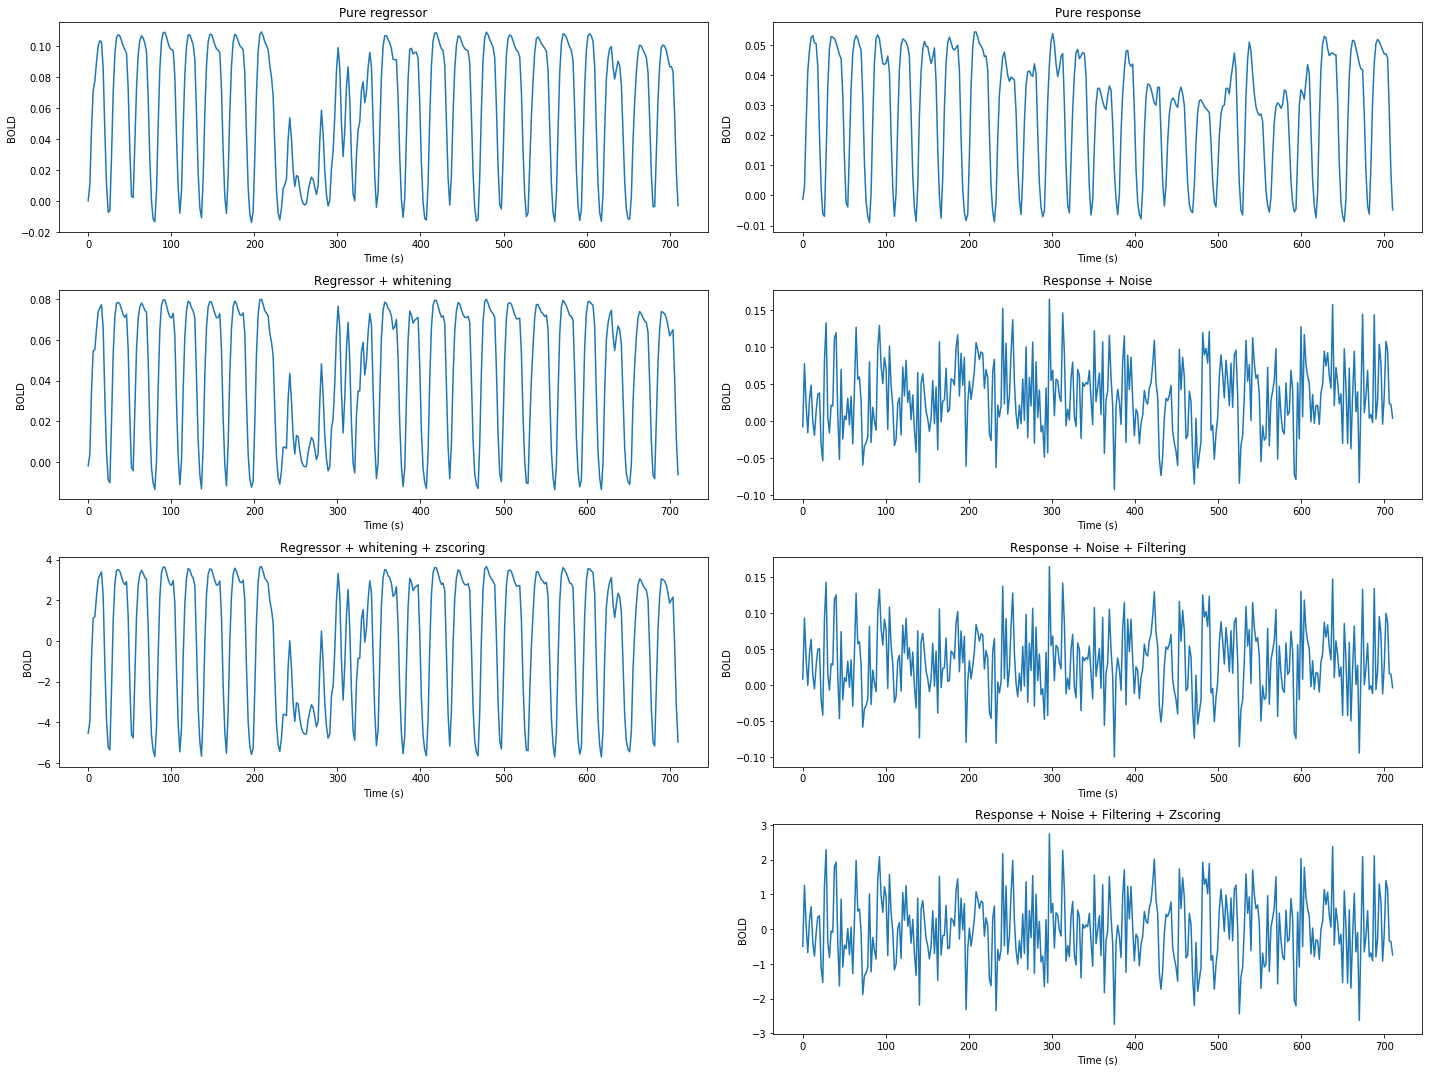

In [55]:
# PICK HERE WHICH REGRESSOR AND RESPONSE TO VISUALIZE
####################################################
k_scheme = 1
k_fit_N = 3
k_true_N = 3
k_fraction = 9
k_subject = 1
k_session = 2
i = 1   # Index of the regressor to visualize
####################################################

y1_plot = copy.deepcopy(y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y2_plot = copy.deepcopy(y_with_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y3_plot = copy.deepcopy(y_after_filtering[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y4_plot = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject][k_session])

x1_plot = copy.deepcopy(X_before_whitening[k_scheme][k_fit_N][k_subject][k_session][:, i])
x2_plot = copy.deepcopy(X_after_whitening[k_scheme][k_fit_N][k_subject][k_session][:, i])
x3_plot = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject][k_session][:, i])

fig = plt.figure(figsize=(20, 15))

ax_up = fig.add_subplot(421)
between_scans_time = 2.0
ax_up.set_xlabel('Time (s)')
ax_up.set_ylabel('BOLD')
ax_up.set_title('Pure regressor')
ax_up.plot(np.linspace(0, between_scans_time*len(x1_plot), len(x1_plot)), x1_plot)

ax_down = fig.add_subplot(423)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening')
ax_down.plot(np.linspace(0, between_scans_time*len(x2_plot), len(x2_plot)), x2_plot)

ax_down = fig.add_subplot(425)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening + zscoring')
ax_down.plot(np.linspace(0, between_scans_time*len(x3_plot), len(x3_plot)), x3_plot)

ax1 = fig.add_subplot(422)
ax1.plot(np.linspace(0, between_scans_time*len(y1_plot), len(y1_plot)), y1_plot)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('BOLD')
ax1.set_title('Pure response')

ax2 = fig.add_subplot(424)
ax2.plot(np.linspace(0, between_scans_time*len(y2_plot), len(y2_plot)), y2_plot)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('BOLD')
ax2.set_title('Response + Noise')

ax3 = fig.add_subplot(426)
ax3.plot(np.linspace(0, between_scans_time*len(y3_plot), len(y3_plot)), y3_plot)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('BOLD')
ax3.set_title('Response + Noise + Filtering')

ax4 = fig.add_subplot(428)
ax4.plot(np.linspace(0, between_scans_time*len(y4_plot), len(y4_plot)), y4_plot)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('BOLD')
ax4.set_title('Response + Noise + Filtering + Zscoring')
fig.tight_layout()
plt.show()


## Regression

### Visualization of an example of training and testing

Here we select arbitrary values of hyperparameters and plot the result for one fit.


Scheme : sigmoid_ppc
true_N = 6
fit_N = 6
Subject n°1
Left-out session : 2
r2_true_test = 0.8349891987435948
r2_raw_test = 0.04960448302180842
rho_true_test = 0.9456432462440212
rho_raw_test = 0.22272063896686467


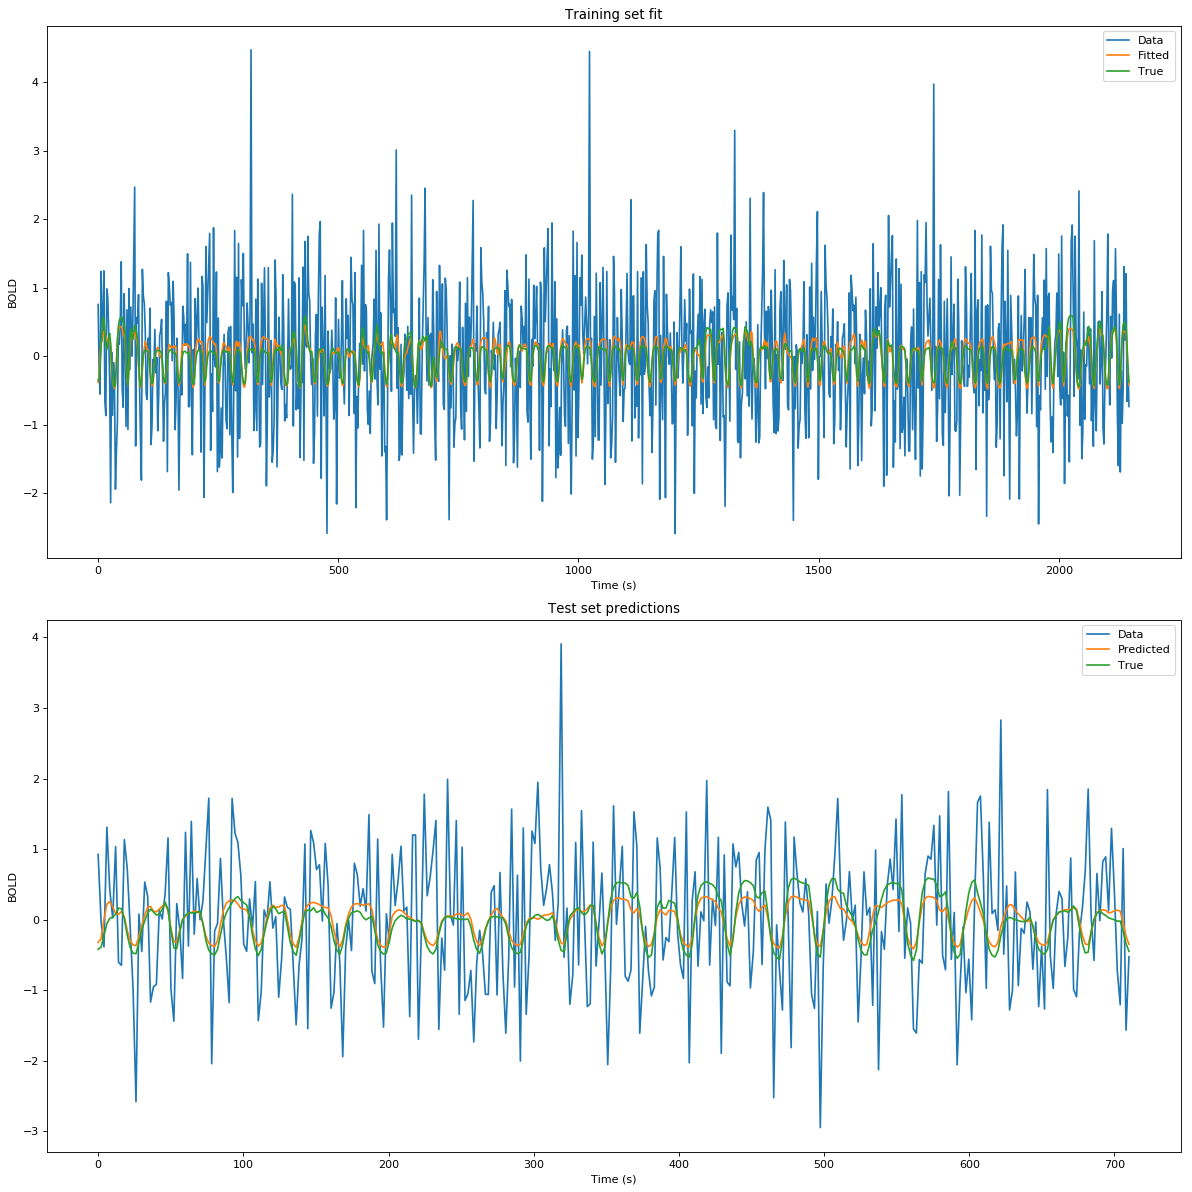

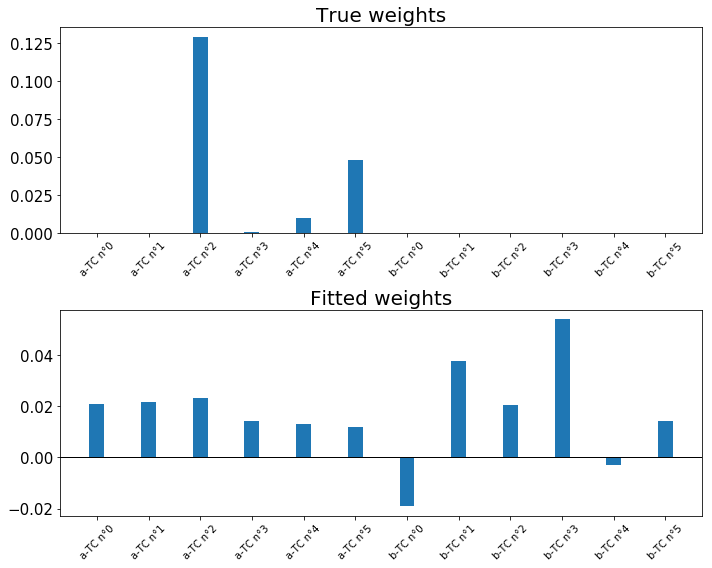

[2.70144032e-08 4.72080798e-06 1.28893141e-01 8.47359615e-04
 1.00249870e-02 4.82018143e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[ 0.02076638  0.02161274  0.02306448  0.01406296  0.0132166   0.01176485
 -0.01913749  0.03776086  0.02066806  0.05396682 -0.00293153  0.01416128]


In [56]:
# PICK HERE WHICH MODEL, SET, ETC. TO VISUALIZE
#######################################
k_scheme =1
k_fit_N =2
k_true_N = 2
k_fraction = 19
k_subject = 1
k_session = 2
#######################################

# k_population = 4
# k_sparsity = 3

# k_fraction = 5*k_sparsity - 4*k_population % 20


true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n'+'Subject n°'+str(k_subject)+'\nLeft-out session : '+str(k_session))

# Current cross-validation matrice and response
X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])
y_without_noise_cv = copy.deepcopy(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject])

X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))

X_test = copy.deepcopy(X_cv[k_session])
y_test = copy.deepcopy(y_cv[k_session])
y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])


# Train the model using the training set
regr.fit(X_train, y_train)
y_hat_train = regr.predict(X_train)

# Make predictions using the testing set
y_pred = np.transpose(np.array([regr.predict(X_test)]))

# Second fit
regr2.fit(y_pred, y_test)
y_pred2 = regr2.predict(y_pred)

# Train and test results
r2_raw_test_unique = r2_score(y_test, y_pred2)
r2_raw_train_unique = r2_score(y_train, y_hat_train)
rho_raw_train_unique = pearsonr(y_train, y_hat_train)[0]
rho_raw_test_unique = pearsonr(y_test, y_pred2)[0]

r2_true_test_unique = r2_score(y_without_noise_test, y_pred2)
r2_true_train_unique = r2_score(y_without_noise_train, y_hat_train)
rho_true_train_unique = pearsonr(y_without_noise_train, y_hat_train)[0]
rho_true_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

# Plot the signal and the response
fig1 = plt.figure(figsize=(15,15), dpi= 80)
ax_y_train = fig1.add_subplot(211)
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_train), len(y_train)), y_train, label='Data')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_hat_train), len(y_hat_train)), y_hat_train, label='Fitted')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_without_noise_train), len(y_without_noise_train)), y_without_noise_train, label='True')
ax_y_train.legend()
ax_y_train.set_xlabel('Time (s)')
ax_y_train.set_ylabel('BOLD')
ax_y_train.set_title('Training set fit')
# Separate sessions
#print(str(y_cv[0]))
dash_line = [None for k in range(n_sessions-1)]
dash_position = 0
for k in range(n_sessions-1):
    dash_position += between_scans_time*len(y_cv[k])
    dash_line[k] = ax_y_train.plot(dash_position*np.ones(10), np.linspace(-1e-3, 1e-3, 10), color='black', linestyle='--')

ax_y_test = fig1.add_subplot(212)
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_test), len(y_test)), y_test, label='Data')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_pred), len(y_pred)), y_pred2, label='Predicted')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_without_noise_test), len(y_without_noise_test)), y_without_noise_test, label='True')
ax_y_test.legend()
ax_y_test.set_xlabel('Time (s)')
ax_y_test.set_ylabel('BOLD')
ax_y_test.set_title('Test set predictions')
fig1.tight_layout()

print('r2_true_test = '+str(r2_true_test_unique))
print('r2_raw_test = '+str(r2_raw_test_unique))
print('rho_true_test = '+str(rho_true_test_unique))
print('rho_raw_test = '+str(rho_raw_test_unique))

## Plot the weights

true_weights = weights[k_scheme][k_true_N][k_fraction][k_subject]
fit_weights = regr.coef_


#print(np.matmul(X_test, fit_weights))

# Plot the true weights
width = 1/np.sqrt((2*true_N))

fig2 = plt.figure(figsize=(10,8))
ax_true_weights = fig2.add_subplot(211)
labels = [None for k in range(2*true_N)]
for k in range(2*true_N):
    if k<true_N:
        labels[k] = 'a-TC n°'+str(k%true_N)
    else:
        labels[k] = 'b-TC n°'+str(k%true_N)
ax_true_weights.bar(labels, true_weights, width=width)
ax_true_weights.tick_params(labelsize=15)
ax_true_weights.set_title('True weights', fontsize=20)
#ax_true_weights.set_ylim([-1, 1])
ax_true_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_true_weights.axhline(0, color="black", linewidth=1)

width = 1/np.sqrt((2*fit_N))
ax_fit_weights = fig2.add_subplot(212)
labels = [None for k in range(2*fit_N)]
for k in range(2*fit_N):
    if k<fit_N:
        labels[k] = 'a-TC n°'+str(k%fit_N)
    else:
        labels[k] = 'b-TC n°'+str(k%fit_N)
ax_fit_weights.bar(labels, fit_weights, width=width)
ax_fit_weights.tick_params(labelsize=15)
ax_fit_weights.set_title('Fitted weights', fontsize=20)
# ax_fit_weights.set_ylim([-1, 1])
ax_fit_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_fit_weights.axhline(0, color="black", linewidth=1)
fig2.tight_layout()
plt.show()    

print(true_weights)
print(fit_weights)


### Cross-validation loops (simulation 1)

In [57]:
# The loops
# The quantity to be computed during the cross validation
r2_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))

r2_true_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_true_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_true_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_true_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))

### BEGINNING OF LOOPS OVER HYPERPARAMETERS
for k_scheme, k_fit_N, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_N), range(n_fractions), range(n_subjects)):
    # Current cross-validation matrix and response
    X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
    y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])
    y_without_noise_cv = copy.deepcopy(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject])

    # LOOP OVER SESSIONS (CV)
    for k_session in range(n_sessions):
        X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
        y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
        X_test = copy.deepcopy(X_cv[k_session])
        y_test = copy.deepcopy(y_cv[k_session])

        y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))
        y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])
        
        # Train the model using the training set
        regr.fit(X_train, y_train)
        y_hat_train = regr.predict(X_train)
        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        y_pred_tmp = np.transpose(np.array([y_pred]))

        # Second fit
        regr2.fit(y_pred_tmp, y_test)
        y_pred2 = regr2.predict(y_pred_tmp)

        # Train and test results
        r2_test_unique = r2_score(y_without_noise_test, y_pred2)
        r2_train_unique = r2_score(y_train, y_hat_train)
        rho_train_unique = pearsonr(y_train, y_hat_train)[0]
        rho_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

        r2_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_train, y_hat_train)
        r2_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_test, y_pred2)
        rho_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_train, y_hat_train)[0]
        rho_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_test, y_pred2)[0]
        rho_true_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_without_noise_train, y_hat_train)[0]
        rho_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_without_noise_test, y_pred2)[0]

        r2_true_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_without_noise_train, y_hat_train)
            
        r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_without_noise_test, y_pred2)

        # with open("output/results/Output.txt", "w") as text_file:
        #     text_file.write('k_fit_scheme={} k_fit_N={} k_true_N={} k_subject={} k_population_fraction={} k_subpopulation_fraction={} k_session={} \nr2={} \n'.format(
        #         k_fit_scheme, k_fit_N, k_true_N, k_subject, k_population_fraction, k_subpopulation_fraction, k_session,
        #         r2_score(y_test, y_pred)))
        # print('Completed : k_fit_scheme={} k_fit_N={} k_true_N={} k_subject={} k_population_fraction={} k_subpopulation_fraction={} k_session={} \nr2={} \nr2_train={}'.format(
        #         k_fit_scheme, k_fit_N, k_true_N, k_subject, k_population_fraction, k_subpopulation_fraction, k_session,
        #         r2_score(y_test, y_pred), r2_train))
    #print('k_scheme : '+str(k_scheme)+'\n'+'k_fit_N = '+str(k_fit_N)+'\nk_true_N = '+str(k_true_N)+'\nk_fraction='+str(k_fraction)+'\nk_subject n°'+str(k_subject)+'\n -----')
# Histogram of r2_train for each fit_N and true_N

# np.save('output/results/r2_test_snr'+str(snr)+'.npy', r2_test)
# np.save('output/results/r2_train_snr'+str(snr)+'.npy', r2_train)
# np.save('output/results/rho_test_snr'+str(snr)+'.npy', rho_test)
# np.save('output/results/rho_train_snr'+str(snr)+'.npy', rho_train)


## Handle the data

### Row data loading and visualization


In [58]:
# Some reloading (run that if the loops have already been performed and results saved)
# r2_test = np.load('output/results/r2_test_snr'+str(snr)+'.npy')
# r2_train = np.load('output/results/r2_train_snr'+str(snr)+'.npy')
# rho_test = np.load('output/results/rho_test_snr'+str(snr)+'.npy')
# rho_train = np.load('output/results/rho_train_snr'+str(snr)+'.npy')
# r2_true_test = np.load('output/results/r2_true_test_snr'+str(snr)+'.npy')
# r2_true_train = np.load('output/results/r2_true_train_snr'+str(snr)+'.npy')
# rho_true_test = np.load('output/results/rho_true_test_snr'+str(snr)+'.npy')
# rho_true_train = np.load('output/results/rho_true_train_snr'+str(snr)+'.npy')

for k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N)
                                                            , range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    if r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] < -3:
        print('k_scheme ='+str(k_scheme)+'\nk_fit_N ='+str(k_fit_N)+'\nk_true_N ='+str(k_true_N)+'\nk_fraction ='+str(k_fraction)
             +'\nk_subject = '+str(k_subject)+'\nk_session = '+str(k_session))
        print('r2_test='+str(r2_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session]))
        print('r2_true_test='+str(r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session])+'\n--------------')

r2_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))

for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):
    r2_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()

#print(r2_raw_test_summary)

In [59]:
#np.save('output/results/r2_test_snr'+str(snr)+'.npy', r2_test)
#np.save('output/results/r2_train_snr'+str(snr)+'.npy', r2_train)
#np.save('output/results/rho_test_snr'+str(snr)+'.npy', rho_test)
#np.save('output/results/rho_train_snr'+str(snr)+'.npy', rho_train)
#np.save('output/results/r2_true_test_snr'+str(snr)+'.npy', r2_true_test)
#np.save('output/results/r2_true_train_snr'+str(snr)+'.npy', r2_true_train)
#np.save('output/results/rho_true_test_snr'+str(snr)+'.npy', rho_true_test)
#np.save('output/results/rho_true_train_snr'+str(snr)+'.npy', rho_true_train)


# Visualize worse r2

for k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    if r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] < -100:
        print('k_scheme : '+str(k_scheme)+'\n'+'k_fit_N = '+str(k_fit_N)+'\nk_fit_N = '+str(k_fit_N)+'\nk_fraction'+str(k_fraction)
          +'\n'+'Subject n°'+str(k_subject)+'\nLeft-out session : '+str(k_session)+'\n -----')


### Visualize results from simulation 1 (one example)

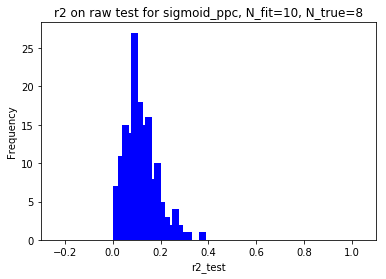

r2 var: 0.004489359378297079
r2 mean: 0.12378710301660989


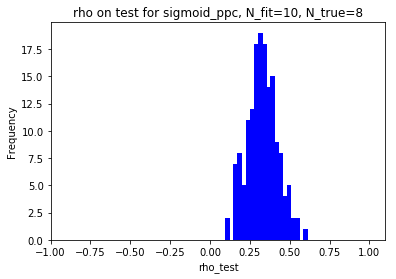

rho var: 0.009039589617808139
rho mean: 0.33874402341414345


In [60]:
# Visualize one specific plot

#########################################
k_scheme = 1
k_fit_N = 4
k_true_N = 3
##########################################

scheme = scheme_array[k_scheme]
fit_N = N_array[k_fit_N]
true_N = N_array[k_true_N]

#r2
metric_name = 'r2'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

# # We set the negative r2 to the same value
# negative_center = -0.2
# n_negative_values = 0
# if metric_name.find('r2')!=-1:
#     for k, metric_value in enumerate(metric):
#         if metric_value <0:
#             metric[k] = negative_center
#             n_negative_values += 1

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
#ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' on '+true_or_raw+' '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

# rho
metric_name = 'rho'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.set_title(metric_name+' on '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))

## Plot confusion matrices for simulation 1

r2 on true test set, sigmoid_ppc


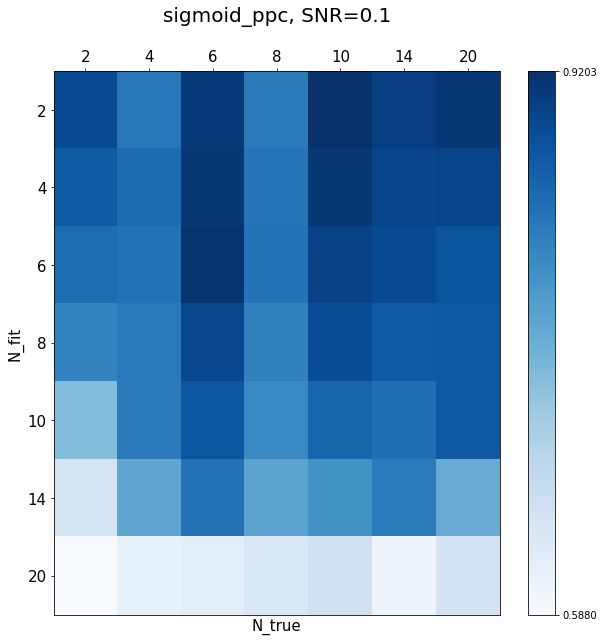

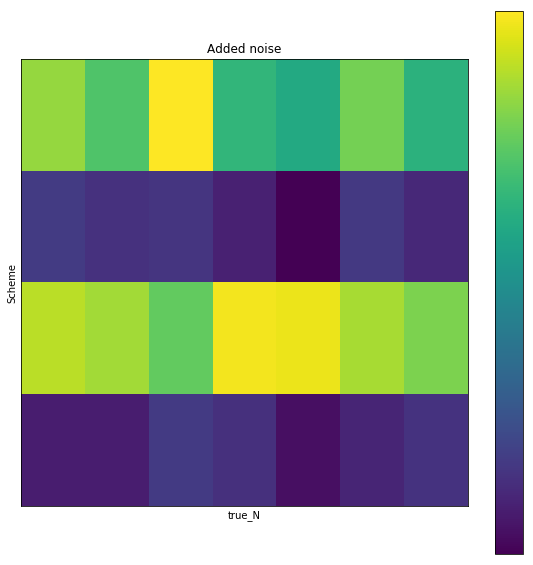

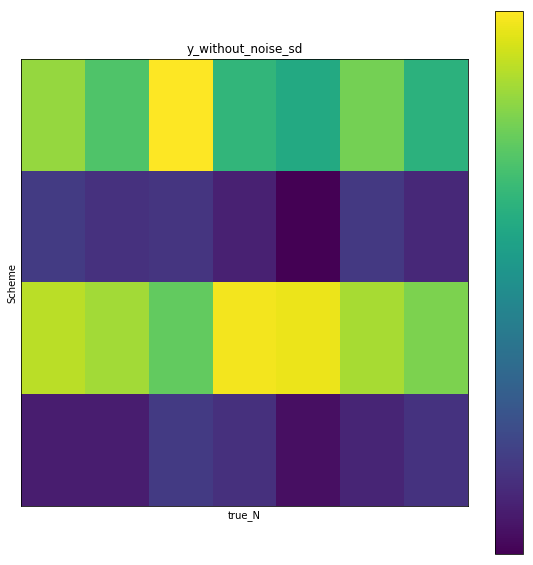

[[0.09809283 0.09612588 0.1129159  0.09144192 0.09054592 0.10410307
  0.08570232]
 [0.05766873 0.05214026 0.0531994  0.04830151 0.04285019 0.05606035
  0.05092922]
 [0.10905865 0.10292528 0.10352068 0.10838473 0.1074856  0.10081243
  0.10146343]
 [0.04988335 0.04806326 0.0551938  0.05379165 0.04727773 0.05267094
  0.05357526]]
[[[-6.07813193e-02  5.78935712e-02  6.78199301e-03 ... -1.40648736e-01
    9.74205039e-03 -4.91714710e-02]
  [-1.82087955e-01  6.34222360e-02 -8.05554289e-02 ... -5.72506221e-02
   -5.07146736e-02  7.92519743e-02]
  [-1.37562527e-01 -1.08144269e-01  5.16991291e-02 ...  8.54224602e-02
   -1.93565238e-01 -9.57607020e-02]
  ...
  [ 1.37462821e-01  9.97076551e-02 -8.03592265e-02 ... -7.80636873e-02
   -8.50206415e-02  7.57803765e-02]
  [-1.42379481e-02  2.36792558e-02 -2.03172547e-01 ...  1.59878670e-01
   -9.34494228e-02 -1.24380580e-01]
  [ 1.67987122e-01 -5.02133687e-02  6.52725961e-02 ...  1.40907825e-01
    1.41473508e-01 -2.04878215e-01]]

 [[-1.72620019e-04 -7

In [63]:
################################
k_scheme = 1
################################
n_fractions = 20
scheme = scheme_array[k_scheme]


metric_name = 'r2'
true_or_raw = 'true'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

print(metric_name+' on '+true_or_raw+' '+train_or_test+' set, '+scheme)

# Visualize the entire confusion matrix
nbins = 20
width = 0.04

#fig, ax = plt.subplots(n_N, n_N, sharex='col', sharey='row', figsize = (10, 10))
#for k_fit_N in range(n_N):
#    for k_true_N in range(n_N):
#        exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))
#        fit_N = N_array[k_fit_N]
#        true_N = N_array[k_true_N]
#        # We set the negative r2 to the same value
#        negative_center = -0.2
#        n_negative_values = 0
#        if metric_name.find('r2')!=-1:
#            for k, metric_value in enumerate(metric):
#                if metric_value <0:
#                    metric[k] = negative_center
#                    n_negative_values += 1
#
#        ax[k_fit_N, k_true_N].hist(metric, bins=nbins, align='left', color='b', width=width)
#        ax[k_fit_N, k_true_N].bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
#        ax[k_fit_N, k_true_N].set_title('N_fit='+str(fit_N)+', N_true='+str(true_N))
#        ax[k_fit_N, k_true_N].set_xlabel('{}_{}'.format(metric_name, train_or_test))
#        ax[k_fit_N, k_true_N].set_ylabel("Frequency")
#        if metric_name.find('r2')!=-1:
#            ax[k_fit_N, k_true_N].set_xlim([-0.3, 1.1])
#        else:
#            ax[k_fit_N, k_true_N].set_xlim([-1, 1])
#        ax[k_fit_N, k_true_N].set_ylim([0, n_fractions*n_subjects*n_sessions/4])
#fig.tight_layout()
#plt.show()

# Plot the confusion matrix of the mean
column_labels = copy.deepcopy(N_array)
row_labels = copy.deepcopy(N_array)

fig, ax = plt.subplots(figsize=(10,10))
fontsize = 15
exec("metric = copy.deepcopy(%s_%s_%s_summary[k_scheme, :, :, :])" % (metric_name, true_or_raw, train_or_test))
# We set the negative r2 to the same value
data = np.mean(metric, axis=2)
heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=np.min(data), vmax=np.max(data))

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('N_fit', fontsize=fontsize)
ax.set_xlabel('N_true', fontsize=fontsize)
plt.title(scheme+', SNR='+str(snr), y=1.08, fontsize=20)
cbar = fig.colorbar(heatmap, ticks=[np.min(data), np.max(data)])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
heatmap = ax.imshow(noise_sd, extent=[0, 1, 0, 1])
cbar = fig.colorbar(heatmap, ticks=[np.min(data), np.max(data)])

# put the major ticks at the middle of each cell
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Added noise')
ax.set_ylabel('Scheme')
ax.set_xlabel('true_N')
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
heatmap = ax.imshow(y_without_noise_sd, extent=[0, 1, 0, 1])
cbar = fig.colorbar(heatmap, ticks=[np.min(data), np.max(data)])

# put the major ticks at the middle of each cell
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('y_without_noise_sd')
ax.set_ylabel('Scheme')
ax.set_xlabel('true_N')
plt.show()

print(y_sd)

print(added_noise)
fig.tight_layout()
plt.show()

31911
41912
61900
61901
61903
61912
[0.3288882  0.36377594 0.31972369 0.37614628 0.38425361 0.31332973
 0.33560809]


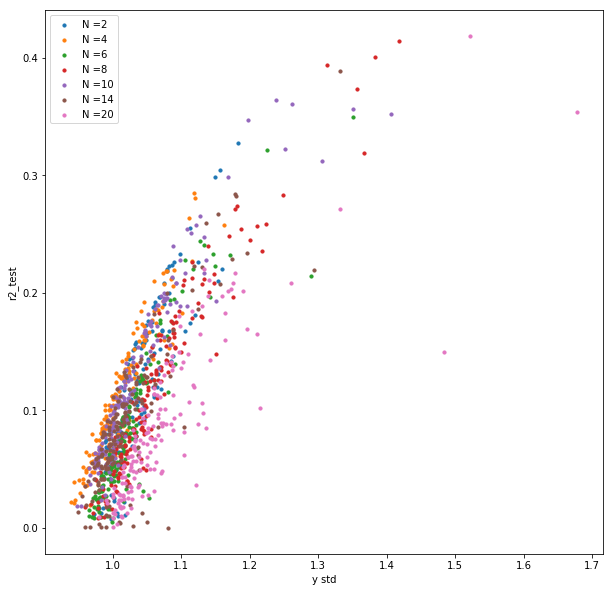

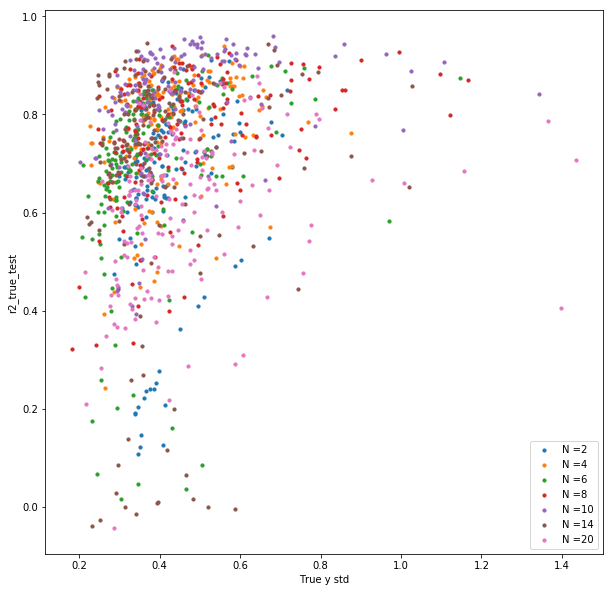

In [62]:
# Visualize amplitude of y_true compared to r2_true

sd_y_true = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))
sd_y = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))

# all y_true sd
for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y_true[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])
    if sd_y_true[k_scheme, k_true_N, k_fraction, k_subject, k_session] > 1.15:
        print(str(k_true_N)+str(k_fraction)+str(k_subject)+str(k_session))

# all y_true sd
for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz[k_scheme][k_true_N][k_fraction][k_subject][k_session])

    
flatten_sd_y_true = sd_y_true[1, :, :, :].flatten()
flatten_sd_y = sd_y[1, :, :, :].flatten()
flatten_r2_true = r2_true_test[1, 6, :, :, :, :].flatten()

sd_y_true_N = np.zeros(n_N)

for k_N_true in range(n_N):
    sd_y_true_N[k_N_true] = np.mean(sd_y_true[1, k_N_true, :, :].flatten())
print(sd_y_true_N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k_true_N in range(n_N):
    x = sd_y[0, k_true_N, :, :, :].flatten()
    y = r2_test[0, 4, k_true_N, :, :, :].flatten()
    ax.scatter(x, y, s=10, label='N ='+str(N_array[k_true_N]))
ax.set_xlabel('y std')
ax.set_ylabel('r2_test')
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k_true_N in range(n_N):
    x = sd_y_true[0, k_true_N, :, :, :].flatten()
    y = r2_true_test[0, 4, k_true_N, :, :, :].flatten()
    ax.scatter(x, y, s=10, label='N ='+str(N_array[k_true_N]))
ax.set_xlabel('True y std')
ax.set_ylabel('r2_true_test')
ax.legend()
plt.show()

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111) 
# for k_true_N in range(n_N):
#     sd_y_true_tmp = sd_y_true[1, k_true_N, :, :, :].flatten()
#     rho_true_test_tmp = rho_true_test[1, 0, k_true_N, :, :, :].flatten()
#     ax.scatter(sd_y_true_tmp, rho_true_test_tmp, s=10, label='N ='+str(N_array[k_true_N]))
# ax.set_xlabel('True y std')
# ax.set_ylabel('r2_true_test')
# ax.legend()
# plt.show()


# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111) 

# k_true_N = 6

# sd_y_true_tmp = sd_y_true[1, k_true_N, :, :, 0].flatten()
# sd_y_train_tmp = np.mean(sd_y_true[1, k_true_N, :, :, 1:], axis=-1).flatten()

# ax.scatter(sd_y_true_tmp, sd_y_train_tmp, s=10, label='N ='+str(N_array[k_true_N]))
# ax.set_xlabel('True y std (train)')
# ax.set_ylabel('True y std (test)')
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111) 
# ax.scatter(flatten_sd_y, flatten_r2)
# ax.set_xlabel('Raw y std')
# ax.set_ylabel('r2_test')
# plt.show()
